![](https://machinelearningmastery.com/wp-content/uploads/2019/02/Plot-of-a-Subset-of-Images-from-the-Fashion-MNIST-Dataset-1024x768.png)

Fashion-MNIST is a dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

**Content**

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255. The training and test data sets have 785 columns. The first column consists of the class labels, and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

To locate a pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27. The pixel is located on row i and column j of a 28 x 28 matrix.

For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

**Labels**

Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot


TL;DR

- Each row is a separate image
- Column 1 is the class label.
- Remaining columns are pixel numbers (784 total).
- Each value is the darkness of the pixel (1 to 255)

In [1]:
product = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
labels = [0,1,2,3,4,5,6,7,8,9]

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (15, 10)

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.callbacks import ReduceLROnPlateau

In [3]:
train =  pd.read_csv('../input/fashionmnist/fashion-mnist_train.csv')
test= pd.read_csv('../input/fashionmnist/fashion-mnist_test.csv')

In [4]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.shape

(60000, 785)

In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test.shape

(10000, 785)

## Exploratory Data Analysis

In [8]:
fig = px.histogram(x=train['label'], 
                   text_auto=True,
                   template='simple_white', 
                   color = train['label'],
                   labels ={'color':'Label', 'x':'Label'},
                   title='Image Labels countplot, Training')

fig.update_layout(
    xaxis_title="Labels",
    yaxis_title="Count")

fig.update_xaxes(ticktext=product,tickvals=np.unique(train['label']), ticklabelstep=1)


fig.show()

In [9]:
fig = px.histogram(x=test['label'], 
                   text_auto=True,
                   template='simple_white', 
                   color = test['label'],
                   labels ={'color':'Label', 'x':'Label'},
                   title='Image Labels countplot, Test')

fig.update_layout(xaxis_title="Labels",yaxis_title="Count")

fig.update_xaxes(ticktext=product,tickvals=np.unique(test['label']), ticklabelstep=1)

fig.show()

In [10]:
y_train = train['label'].values
X_train = train[train.columns[1:]].values/255
y_test = test['label'].values
X_test = test[test.columns[1:]].values/255

In [11]:
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

60000 train samples
10000 test samples


**Convolutional Neural Network** has become very common in the field of computer vision in recent years. But it comes with a severe restriction regarding the size of the input image. Most convolutional neural networks are designed in a way so that they can only accept images of a fixed size. 

This creates several challenges during data acquisition and model deployment. The common practice to overcome this limitation is to reshape the input images so that they can be fed into the networks.

In [12]:
X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)

In [13]:
print(len(y_train),'image labels')

60000 image labels


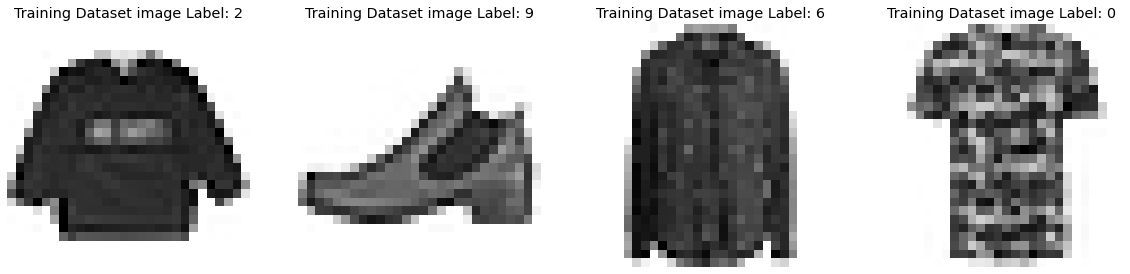

In [14]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,15))
for ax, image, label in zip(axes, X_train, y_train):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Training Dataset image Label: {label}")    

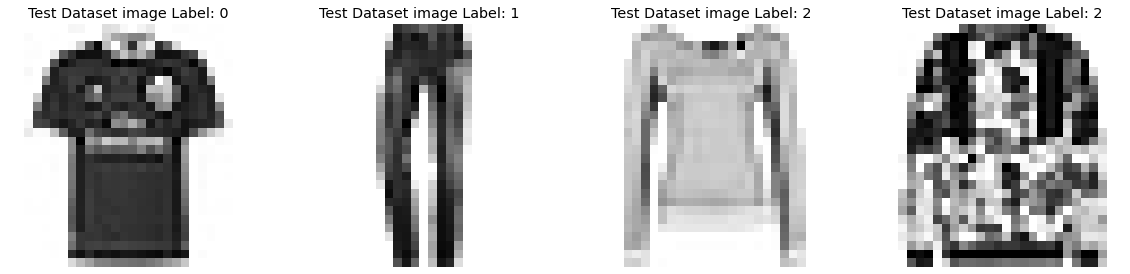

In [15]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,15))
for ax, image,label in zip(axes, X_test, y_test):
    ax.set_axis_off()
    image = image.reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Test Dataset image Label: {label}")    

In [16]:
print('There are {} unique image labels in the training dataset'.format(len(train['label'].unique())))

There are 10 unique image labels in the training dataset


In [17]:
print('{} are unique image labels in the training dataset'.format(np.unique(train['label'])))

[0 1 2 3 4 5 6 7 8 9] are unique image labels in the training dataset


## Data augmentation

**Data Augmentation** is a technique that can be used to artificially expand the size of a training set by creating modified data from the existing one. It is a good practice to use DA if you want to prevent overfitting, or the initial dataset is too small to train on, or even if you want to squeeze better performance from your model. In general, DA is frequently used when building a DL model. Although the augmentation is done in Deep learning, you can also augment the data for the ML problems as well.

You can augment:

1. *Audio*
2. *Text*
3. *Images*
4. *Any other types of data*

We will focus on image augmentations as those are the most popular ones. Nevertheless, augmenting other types of data is as efficient and easy. That is why it’s good to remember some common techniques which can be performed to augment the data.

**Data Augmentation techniques**

We can apply various changes to the initial data. 

For example, for images we can use:

1. Geometric transformations – you can randomly flip, crop, rotate or translate images, and that is just the tip of the iceberg
2. Color space transformations – change RGB color channels, intensify any color
3. Kernel filters – sharpen or blur an image 
4. Random Erasing – delete a part of the initial image
5. Mixing images – basically, mix images with one another. Might be counterintuitive but it works

For text there are:
1. Word/sentence shuffling
2. Word replacement – replace words with synonyms
3. Syntax-tree manipulation – paraphrase the sentence to be grammatically correct using the same words

For audio augmentation you can use:

1. Noise injection
2. Shifting
3. Changing the speed of the tape
...*and many more*

Moreover, the greatest advantage of the augmentation techniques is that you may use all of them at once. Thus, you may get plenty of unique samples of data from the initial one. Below are some of the ways that you can augment data. The layers apply random augmentation transforms to a batch of images. They are only active during training.

- tf.keras.layers.RandomCrop
- tf.keras.layers.RandomFlip
- tf.keras.layers.RandomTranslation
- tf.keras.layers.RandomRotation
- tf.keras.layers.RandomZoom
- tf.keras.layers.RandomHeight
- tf.keras.layers.RandomWidth
- tf.keras.layers.RandomContrast

We are using the `RandomFlip` because our data is usually grayscale and is not rotated or has any other contrast. However we do have specified the both Horizontal and Vertical Flip

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(28, 
                                                              28,
                                                              1))
  ]
)

2022-09-11 16:58:27.050954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 16:58:27.056351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 16:58:27.057114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-11 16:58:27.058466: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Below is the original Image from the training dataset:-

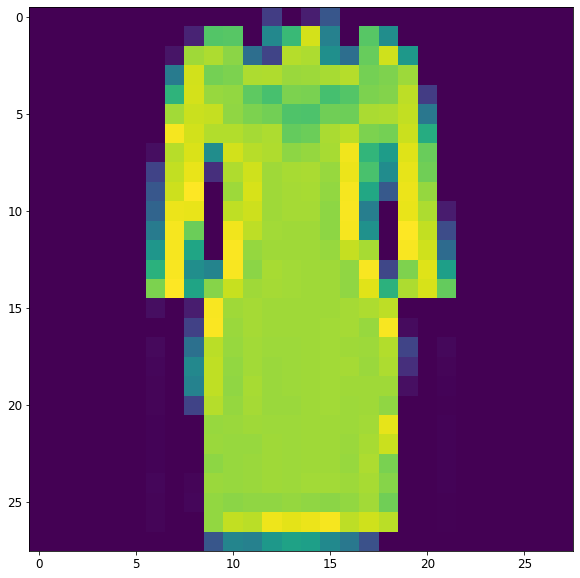

In [19]:
plt.imshow(X_train[4]);

Here is an augmented image:-

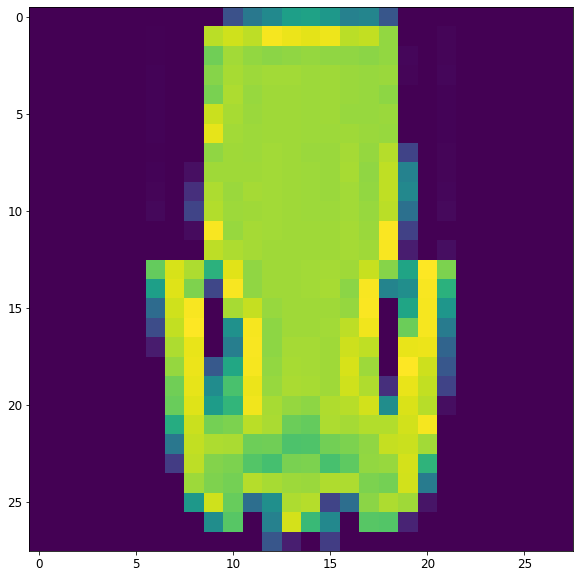

In [20]:
plt.imshow(data_augmentation(X_train)[4]);

## Model Creation and Training

In [21]:
model = Sequential()

#Augmentation Layer
model.add(data_augmentation)

#Input Layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=(28,28,1))),
model.add(MaxPool2D(pool_size=(2, 2), strides=2)),
model.add(BatchNormalization())

#Hidden Layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#Dropout Layer
model.add(Dropout(0.5))

#Hidden Layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

#Hidden Layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

#Hidden Layer
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())

#Output Layer
model.add(Flatten())
model.add(Dense(10, activation = "softmax"))

#Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)         

### Model architecture diagram

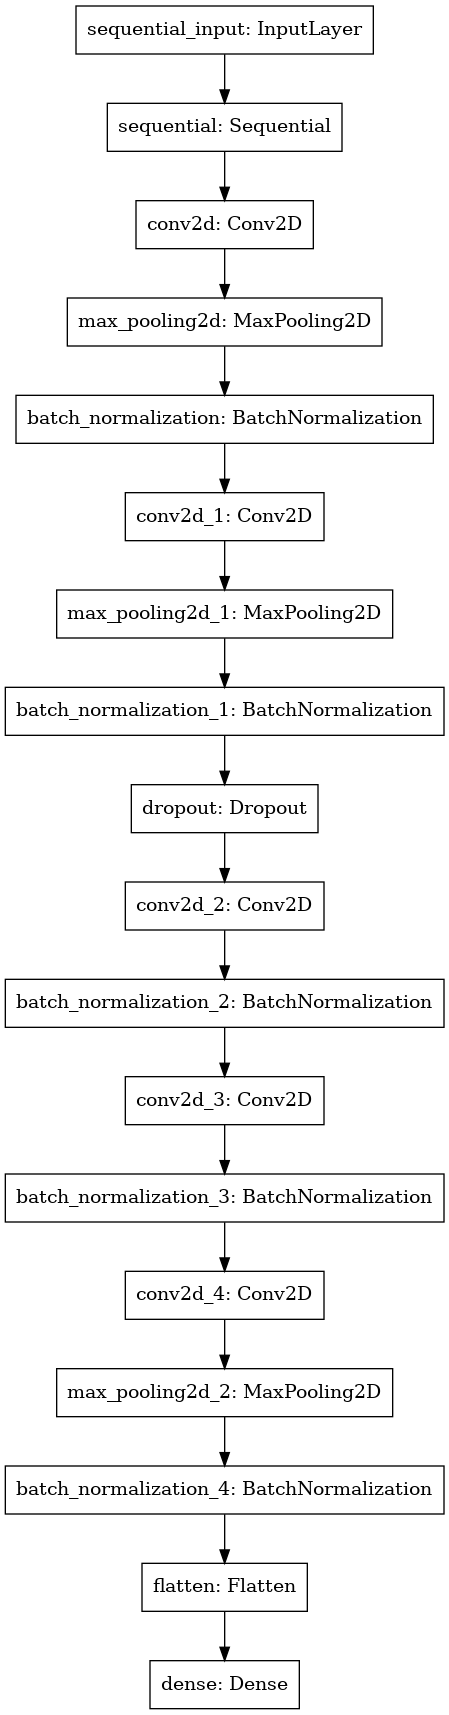

In [22]:
tensorflow.keras.utils.plot_model(
    model,
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None
)

In [23]:
def get_lr_metric(optimizer):
    def learningrate(y_test, y_pred):
        return optimizer._decayed_lr(tensorflow.float32)
    return learningrate

In [24]:
ReduceLR=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', 
                            epsilon=0.0001, cooldown=0, min_lr=0)

optimizer = keras.optimizers.Adam(learning_rate=0.01)

callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)

learningrate = get_lr_metric(optimizer)
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy', learningrate])

In [25]:
print('X Train Shape', X_train.shape)

X Train Shape (60000, 28, 28, 1)


## Training the CNN Model

In [26]:
history = model.fit(x=X_train,y=y_train,epochs=100,
                    batch_size=500,validation_data = (X_test,y_test), 
                    validation_batch_size=500, callbacks=[callback, ReduceLR])

2022-09-11 16:58:33.122348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-11 16:58:35.173567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


120/120 [==============================] - 10s 18ms/step - loss: 0.7344 - accuracy: 0.7391 - learningrate: 0.0100 - val_loss: 3.0805 - val_accuracy: 0.2184 - val_learningrate: 0.0100
Epoch 2/100
120/120 [==============================] - 2s 17ms/step - loss: 0.4155 - accuracy: 0.8493 - learningrate: 0.0100 - val_loss: 2.7673 - val_accuracy: 0.3010 - val_learningrate: 0.0100
Epoch 3/100
120/120 [==============================] - 2s 16ms/step - loss: 0.3613 - accuracy: 0.8683 - learningrate: 0.0100 - val_loss: 0.8770 - val_accuracy: 0.6886 - val_learningrate: 0.0100
Epoch 4/100
120/120 [==============================] - 2s 18ms/step - loss: 0.3398 - accuracy: 0.8769 - learningrate: 0.0100 - val_loss: 0.4407 - val_accuracy: 0.8375 - val_learningrate: 0.0100
Epoch 5/100
120/120 [==============================] - 2s 16ms/step - loss: 0.3174 - accuracy: 0.8841 - learningrate: 0.0100 - val_loss: 0.3449 - val_accuracy: 0.8767 - val_learningrate: 0.0100
Epoch 6/100
120/120 [====================

## Predictions

### Confusion Matrix

In [27]:
#Making Prediction
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=1)

#Making the Confusion Matrix
confusionmatrix = np.around(confusion_matrix(y_test, y_pred, normalize='true'),3)

#Plotting the Confusion Matrix
fig = px.imshow(confusionmatrix, 
                text_auto=True, 
                color_continuous_scale=px.colors.sequential.Teal, 
                aspect="auto", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))

fig.update_yaxes(ticktext=product,tickvals=np.unique(y_train), ticklabelstep=1)

fig.update_xaxes(side="bottom", ticktext=product,tickvals=np.unique(y_train), ticklabelstep=1)

fig.show()

### Loss and Accuracy Plots

In [28]:
fig = px.line(x=range(len(history.history['loss'])),
             y=np.around(history.history['loss'],4), 
              color_discrete_sequence=["steelblue"],
              template='simple_white',
              labels = {'x': 'Epoch', 'y':'Loss'},
              title = ' Training Loss Plot',
                      markers=True)

fig.update_layout(xaxis_title="Epochs",yaxis_title=" Loss")

fig1 = px.line(x=range(len(history.history['val_loss'])),
               y=np.around(history.history['val_loss'],4), 
               template='simple_white',
               labels = {'x': 'Epoch', 'y':'Validation Loss'},
               color_discrete_sequence=["orange"],
               title = 'Validation Loss Plot', markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title=" Validation Loss")

fig.show()
fig1.show()

In [29]:
fig = px.line(x = range(len(history.history['accuracy'])),
              y=np.around(history.history['accuracy'],4), color_discrete_sequence=["steelblue"],
              labels = {'x': 'Epoch', 'y':'Accuracy'},
              template='simple_white',
              title = 'Training Accuracy Plot', 
              #text=[ '%.3f' % elem for elem in history.history['accuracy'] ],
              markers=True)
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title=" Accuracy")
fig.update_traces(textposition="top center")

#2nd Plot
fig1 = px.line(x= range(len(history.history['val_accuracy'])), 
               y= np.around(history.history['val_accuracy'],4), 
               labels = {'x': 'Epoch', 'y':'Validation Accuracy'},
               template='simple_white',
               title = 'Validation Accuracy Plot', 
               color_discrete_sequence=["orange"],
               markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title="Validation Accuracy")

fig1.update_traces(textposition="top center")

fig.show()
fig1.show()

In [30]:
fig = px.line(x = range(len(history.history['learningrate'])),
              y=history.history['learningrate'], color_discrete_sequence=["steelblue"],
              labels = {'x': 'Epoch', 'y':'Learning Rate'},
              template='simple_white',
              title = 'Learning Rate Plot', 
              #text=[ '%.3f' % elem for elem in history.history['accuracy'] ],
              markers=True)
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title=" Learning Rate")
fig.update_traces(textposition="top center")

#2nd Plot
fig1 = px.line(x= range(len(history.history['val_learningrate'])), 
               y= history.history['val_learningrate'], 
               labels = {'x': 'Epoch', 'y':'Validation Learning Rate'},
               template='simple_white',
               title = 'Validation Learning Rate Plot', 
               color_discrete_sequence=["orange"],
               markers=True)

fig1.update_layout(xaxis_title="Epochs",yaxis_title="Validation Learning Rate")

fig1.update_traces(textposition="top center")

fig.show()
fig1.show()

Learning Rate stayed the same during the entire training.

In [31]:
print('=== CLASSIFICATION REPORT ===')
print(classification_report(y_test, y_pred))

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.96      0.78      0.86      1000
           3       0.95      0.91      0.93      1000
           4       0.80      0.94      0.87      1000
           5       0.95      0.99      0.97      1000
           6       0.75      0.80      0.78      1000
           7       0.98      0.88      0.93      1000
           8       0.99      0.99      0.99      1000
           9       0.92      0.98      0.95      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



In [32]:
count = {int(value): list(y_test[y_test != y_pred]).count(value) for value in set(y_test[y_test != y_pred])}
maxvalue = max(count, key=count.get)
#Setting the color of the most misqualified labels to 'indianred'
colors = {}
keys = range(len(np.unique(y_train)))
for i in keys:
    for x in ['lightgray']:
        for j in ['indianred']:
            colors[i] = x
            colors[maxvalue] = j
print(colors)

{0: 'lightgray', 2: 'indianred', 1: 'lightgray', 3: 'lightgray', 4: 'lightgray', 5: 'lightgray', 6: 'lightgray', 7: 'lightgray', 8: 'lightgray', 9: 'lightgray'}


## Misclassified Plot

In [33]:
fig = px.histogram(x=y_test[y_test != y_pred], 
                   template='simple_white', 
                   text_auto=True,
                   color = y_test[y_test != y_pred],
                   labels={'x':'Product', 'color': 'Label'},
                   color_discrete_map = colors,
                  title='Misclassified Labels Count')

fig.update_layout(xaxis_title="Image Labels",yaxis_title=" Count")

fig.update_xaxes(ticktext= product,
                 tickvals = np.unique(y_train),
                 ticklabelstep=1, 
                 type="category", 
                 categoryorder="total descending")

fig.show()

## Misclassification Error Rate

In [34]:
#Cases where misclassification has been done
print(len(y_test[y_test != y_pred]),'cases out of', len(X_test), 'cases are being misclassified which gives us an error rate of', np.around((len(y_test[y_test != y_pred])/len(X_test)*100),4))

859 cases out of 10000 cases are being misclassified which gives us an error rate of 8.59


**Further Reading**

1. Digit Classification - ANNs vs CNNs https://bit.ly/3pC4xec
2. Image augmentation and overfitting - YouTube Video https://bit.ly/3QJT5Jp
3. Google Colab Notebook - https://bit.ly/3Ac5xe8
4. Data Augmentation Jupyter Notebook https://bit.ly/3Kew0Mx